In [1]:
# Kernel: Python 3.11.5
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.io
import datetime
import statistics

In [2]:
filename = "..\input_data\KaneWeir_Discharge.xlsx"
data = pd.read_excel(filename)
data = data[(data['Discharge (L/s)'] >= 1E-15) & (data['Discharge (L/s)'] <= 10e4)]
years = ['2006', '2014', '2016', '2017']
start_date = '07-01'
end_date = '09-01'
data['Year'] = data['Date'].dt.year.astype(str)
data = data[data['Year'].isin(years)]
data['Date'] = pd.to_datetime(data['Date'])
data['Minute_of_Year'] = (data['Date'] - pd.to_datetime(data['Year'] + '-' + start_date)) / pd.Timedelta(minutes=1)
data = data[data['Date'].between(data['Year'] + '-' + start_date, data['Year'] + '-' + end_date)]
for year in years:
    data_year = data[(data['Year'] == year) & 
                            (data['Date'].between(f"{year}-07-01", f"{year}-08-12"))]['Discharge (L/s)']
    print(f"Quantiles for {year}:{np.quantile(data_year, [0.25, 0.5, 0.75])}")
    print(f"max for {year}:{np.max(data_year)}")
    print(f"min for {year}:{np.min(data_year)}")
 
quartiles_combined_observed = data['Discharge (L/s)'].quantile([0.25,0.50,0.75])
print(f"Quartiles for combined discharge: Q1={(quartiles_combined_observed.loc[0.25])}, Q2={(quartiles_combined_observed.loc[0.5])}, Q3={(quartiles_combined_observed.loc[0.75])}")
Max_combined_observed = data['Discharge (L/s)'].max()
Min_combined_observed = data['Discharge (L/s)'].min()
print(f"Max, Min for combined discharge: Max={Max_combined_observed}, Min={Min_combined_observed}")

Quantiles for 2006:[ 3.9  8.  20.7]
max for 2006:367.70000000000005
min for 2006:1.7
Quantiles for 2014:[13.9 41.4 73. ]
max for 2014:544.5
min for 2014:1.1
Quantiles for 2016:[ 0.7   2.94 11.39]
max for 2016:180.07000000000002
min for 2016:0.01
Quantiles for 2017:[ 9.83 20.88 44.7 ]
max for 2017:310.34000000000003
min for 2017:0.01
Quartiles for combined discharge: Q1=4.8625, Q2=17.115000000000002, Q3=49.7375
Max, Min for combined discharge: Max=544.5, Min=0.01


In [4]:
# Read the model data
oc = pd.read_csv('..\output_data\Q_gw_Kane_model_revisionB.csv', header=None)
oc.columns = ['Model_Discharge']
oc['Log_Model_Discharge'] = np.log10(oc['Model_Discharge'])
# oc['Log_Model_Discharge'].replace([np.inf, -np.inf, np.nan], 0)
# oc['Log_Model_Discharge'] = oc['Log_Model_Discharge'].dropna()
oc = oc.loc[oc['Model_Discharge'] != 0]
oc['Log_Model_Discharge'] = np.log10(oc['Model_Discharge'])
oc.head()

,Model_Discharge,Log_Model_Discharge
0,16.297258,1.212115
1,25.637896,1.408882
2,0.362506,-0.440685
3,11.340366,1.054627
4,0.490448,-0.309407


In [5]:
quartiles_model = oc['Model_Discharge'].quantile([0.25, 0.5, 0.75])
print(f"Quartiles for modelled discharge: Q1={(quartiles_model.loc[0.25])}, Q2={(quartiles_model.loc[0.5])}, Q3={(quartiles_model.loc[0.75])}")
max_model = oc['Model_Discharge'].max()
min_model = oc['Model_Discharge'].min()
print(f"Max and Min for modelled discharge: max={(max_model)}, min={(min_model)}")


Quartiles for modelled discharge: Q1=0.105546364560854, Q2=1.10457689491419, Q3=11.2551092102522
Max and Min for modelled discharge: max=424.382560110664, min=8.375778980782171e-09


In [6]:
count = np.sum((oc['Model_Discharge'] >= Min_combined_observed) & (oc['Model_Discharge'] <= Max_combined_observed))
count

7461261

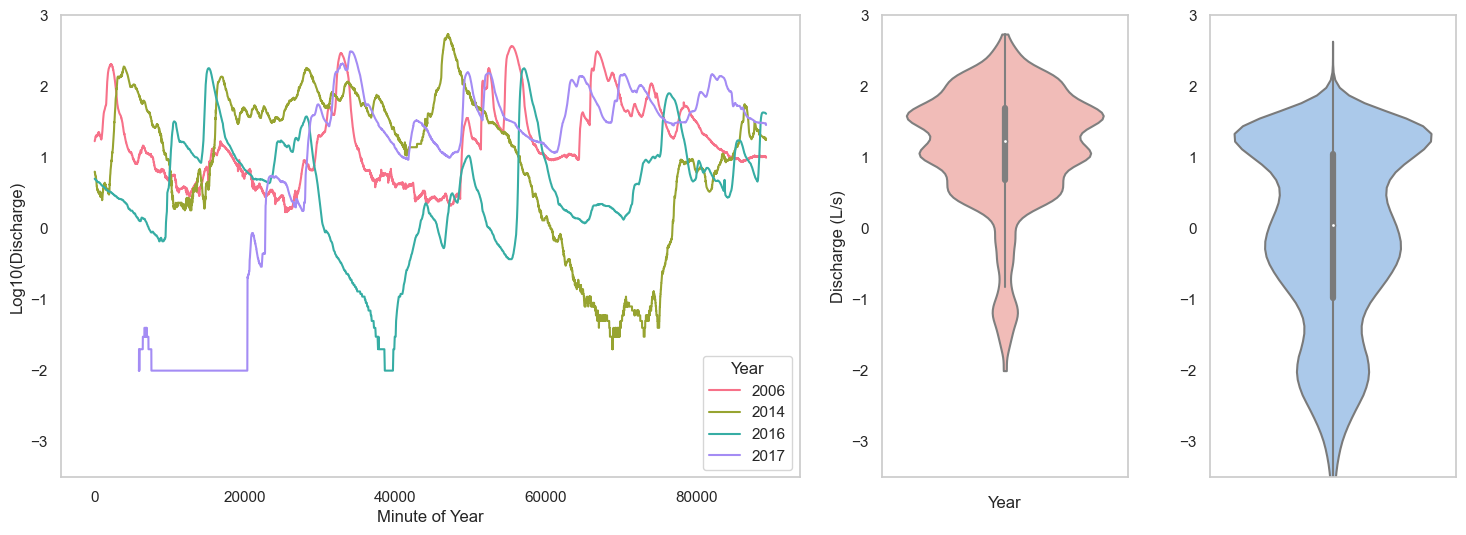

In [21]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1.5, 0.5, 0.5]})
# Plot the time series data
sns.lineplot(ax=ax[0], data=data, x='Minute_of_Year', y=np.log10(data['Discharge (L/s)']), hue='Year', palette="husl", legend='full')
ax[0].set_ylabel('Log10(Discharge)')
ax[0].set_xlabel('Minute of Year')
ax[0].legend(title='Year')
ax[0].grid(False)
ax[0].set_ylim(-3.5, 3)
# Violin plot for discharge all years
sns.violinplot(ax=ax[1], data=data['Discharge (L/s)'], y=np.log10(data['Discharge (L/s)']), palette="Pastel1", dodge=False, orient='v', cut = 0)
ax[1].set_xlabel('Year')
ax[1].grid(False)
ax[1].set_ylim(-3.5, 3)
# Violin plot for model data
oc['Log_Model_Discharge'] = oc['Log_Model_Discharge'].dropna()
sns.violinplot(ax=ax[2], y=oc['Log_Model_Discharge'], palette="pastel", dodge=False, cut = 0)
ax[2].set_ylabel('')
ax[2].set_ylim(-3.5, 3)
ax[2].grid(False)
plt.show()
#fig.savefig('Stack_discharge_comparison.pdf')
#fig.savefig('Kane_discharge_comparison_allyears.pdf')
# fig.savefig('Kane_discharge_comparison_allyears_updated_revisionB.pdf')

In [9]:
xls = pd.read_excel("..\input_data\Mukherjee_etal_Supplementary_Chemistry.xlsx", sheet_name=['DOC_GW', 'DOC_Riv'])

DOC_GW_df = xls['DOC_GW']
DOC_Riv_df = xls['DOC_Riv']
DOC_GW = DOC_GW_df.DOC_uM 
DOC_GW = DOC_GW * 1e-6 
DOC_GW_mean = statistics.mean(DOC_GW)
DOC_GW_SD = statistics.stdev(DOC_GW)
C_soil_model =  pd.read_csv('..\output_data\DOC_flux_Kane_Model.csv', header = None)
DOC_Riv = DOC_Riv_df.DOC_uM 
DOC_Riv = DOC_Riv.apply(pd.to_numeric, errors = 'coerce')
DOC_Riv.dropna(inplace=True)
DOC_Riv = DOC_Riv * 1e-6
DOC_Riv_mean = statistics.mean(DOC_Riv)
DOC_Riv_SD = statistics.stdev(DOC_Riv)

filename = "..\input_data\KaneWeir_Discharge.xlsx"
IC_Discharge = pd.read_excel(filename)
IC_Discharge = IC_Discharge[(IC_Discharge['Discharge (L/s)'] >= 1E-15) & (IC_Discharge['Discharge (L/s)'] <= 10e4)]

years = ['2006', '2014', '2016', '2017']
start_date = '07-01'
end_date = '09-01'

IC_Discharge_2006 = IC_Discharge[IC_Discharge['Date'].between(f"{2006}-{start_date}", f"{2006}-{end_date}")]
IC_Discharge_2014 = IC_Discharge[IC_Discharge['Date'].between(f"{2014}-{start_date}", f"{2014}-{end_date}")]
IC_Discharge_2016 = IC_Discharge[IC_Discharge['Date'].between(f"{2016}-{start_date}", f"{2016}-{end_date}")]
IC_Discharge_2017 = IC_Discharge[IC_Discharge['Date'].between(f"{2017}-{start_date}", f"{2017}-{end_date}")]

IC_Discharge_2006['Minute of Year'] = (pd.to_datetime(IC_Discharge_2006['Date']) - pd.to_datetime(f"{2006}-{start_date}")) / pd.Timedelta(minutes=1)
IC_Discharge_2014['Minute of Year'] = (pd.to_datetime(IC_Discharge_2014['Date']) - pd.to_datetime(f"{2014}-{start_date}")) / pd.Timedelta(minutes=1)
IC_Discharge_2016['Minute of Year'] = (pd.to_datetime(IC_Discharge_2016['Date']) - pd.to_datetime(f"{2016}-{start_date}")) / pd.Timedelta(minutes=1)
IC_Discharge_2017['Minute of Year'] = (pd.to_datetime(IC_Discharge_2017['Date']) - pd.to_datetime(f"{2017}-{start_date}")) / pd.Timedelta(minutes=1)

DOC_Riv_Flux_2006 = IC_Discharge_2006['Discharge (L/s)'] * DOC_Riv_mean
DOC_Riv_Flux_2014 = IC_Discharge_2014['Discharge (L/s)'] * DOC_Riv_mean
DOC_Riv_Flux_2016 = IC_Discharge_2016['Discharge (L/s)'] * DOC_Riv_mean
DOC_Riv_Flux_2017 = IC_Discharge_2017['Discharge (L/s)'] * DOC_Riv_mean

DOC_Riv_Flux_2017_meanplusSD = IC_Discharge_2017['Discharge (L/s)'] * (DOC_Riv_mean+DOC_Riv_SD)
DOC_Riv_Flux_2017_meanminusSD = IC_Discharge_2017['Discharge (L/s)'] * (DOC_Riv_mean-DOC_Riv_SD)



C:\Users\nm32873\AppData\Local\Temp\ipykernel_232432\1793507670.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IC_Discharge_2006['Minute of Year'] = (pd.to_datetime(IC_Discharge_2006['Date']) - pd.to_datetime(f"{2006}-{start_date}")) / pd.Timedelta(minutes=1)
C:\Users\nm32873\AppData\Local\Temp\ipykernel_232432\1793507670.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IC_Discharge_2014['Minute of Year'] = (pd.to_datetime(IC_Discharge_2014['Date']) - pd.to_datetime(f"{2014}-{start_date}")) / pd.T

In [10]:
quartiles_DOCFluxObs_2006 = DOC_Riv_Flux_2006.quantile([0.25,0.50,0.75])
max_DOCFluxObs_2006 = DOC_Riv_Flux_2006.max()
min_DOCFluxObs_2006 = DOC_Riv_Flux_2006.min()
print(f"Quartiles for DOC Flux (2006): Q1={(quartiles_DOCFluxObs_2006.loc[0.25])*12.01}, Q2={(quartiles_DOCFluxObs_2006.loc[0.5])*12.01}, Q3={(quartiles_DOCFluxObs_2006.loc[0.75])*12.01}")
print(f"Max and Min for DOC Flux (2006): Max={max_DOCFluxObs_2006*12.01}, Min={min_DOCFluxObs_2006*12.01}")

quartiles_DOCFluxObs_2014 = DOC_Riv_Flux_2014.quantile([0.25,0.50,0.75])
max_DOCFluxObs_2014 = DOC_Riv_Flux_2014.max()
min_DOCFluxObs_2014 = DOC_Riv_Flux_2014.min()
print(f"Quartiles for DOC Flux (2014): Q1={(quartiles_DOCFluxObs_2014.loc[0.25])*12.01}, Q2={(quartiles_DOCFluxObs_2014.loc[0.5])*12.01}, Q3={(quartiles_DOCFluxObs_2014.loc[0.75])*12.01}")
print(f"Max and Min for DOC Flux (2014): Max={max_DOCFluxObs_2014*12.01}, Min={min_DOCFluxObs_2014*12.01}")

quartiles_DOCFluxObs_2016 = DOC_Riv_Flux_2016.quantile([0.25,0.50,0.75])
max_DOCFluxObs_2016 = DOC_Riv_Flux_2016.max()
min_DOCFluxObs_2016 = DOC_Riv_Flux_2016.min()
print(f"Quartiles for DOC Flux (2016): Q1={(quartiles_DOCFluxObs_2016.loc[0.25])*12.01}, Q2={(quartiles_DOCFluxObs_2016.loc[0.5])*12.01}, Q3={(quartiles_DOCFluxObs_2016.loc[0.75])*12.01}")
print(f"Max and Min for DOC Flux (2016): Max={max_DOCFluxObs_2016*12.01}, Min={min_DOCFluxObs_2016*12.01}")

quartiles_DOCFluxObs_2017 = DOC_Riv_Flux_2017.quantile([0.25,0.50,0.75])
max_DOCFluxObs_2017 = DOC_Riv_Flux_2017.max()
min_DOCFluxObs_2017 = DOC_Riv_Flux_2017.min()
print(f"Quartiles for DOC Flux (2017): Q1={(quartiles_DOCFluxObs_2017.loc[0.25])*12.01}, Q2={(quartiles_DOCFluxObs_2017.loc[0.5])*12.01}, Q3={(quartiles_DOCFluxObs_2017.loc[0.75])*12.01}")
print(f"Max and Min for DOC Flux (2017): Max={max_DOCFluxObs_2017*12.01}, Min={min_DOCFluxObs_2017*12.01}")

Quartiles for DOC Flux (2006): Q1=0.07192286506132076, Q2=0.14646110703396226, Q3=0.48515241705000006
Max and Min for DOC Flux (2006): Max=4.808370451463208, Min=0.022230703746226415
Quartiles for DOC Flux (2014): Q1=0.03923065366981132, Q2=0.25499924885377356, Q3=0.7179209621575472
Max and Min for DOC Flux (2014): Max=7.120363641070755, Min=0.0002615376911320755
Quartiles for DOC Flux (2016): Q1=0.016607643386886792, Q2=0.04773062863160377, Q3=0.13560729285198114
Max and Min for DOC Flux (2016): Max=2.3547546021076418, Min=0.00013076884556603775
Quartiles for DOC Flux (2017): Q1=0.2034763237007547, Q2=0.4351987180437735, Q3=1.0107124073799056
Max and Min for DOC Flux (2017): Max=4.058280353296416, Min=0.00013076884556603775


In [11]:
filtered_data = IC_Discharge[IC_Discharge['Date'].dt.year.isin([int(year) for year in years])]

In [12]:
DOC_flux_all = filtered_data['Discharge (L/s)']* DOC_Riv_mean
quartiles_combined_DOCFlux_all = DOC_flux_all.quantile([0.25,0.50,0.75])
Max_combined_DOCFlux_all = DOC_flux_all.max()
Min_combined_DOCFlux_all = DOC_flux_all.min()
print(f"Quartiles for DOC Flux (all): Q1={(quartiles_combined_DOCFlux_all.loc[0.25])*12.01}, Q2={(quartiles_combined_DOCFlux_all.loc[0.5])*12.01}, Q3={(quartiles_combined_DOCFlux_all.loc[0.75])*12.01}")
print(f"Max and Min for DOC Flux (all): Max={Max_combined_DOCFlux_all*12.01}, Min={Min_combined_DOCFlux_all*12.01}")

Quartiles for DOC Flux (all): Q1=0.09454587534424529, Q2=0.23538392201886796, Q3=0.9479433615082076
Max and Min for DOC Flux (all): Max=15.232216669223206, Min=0.00013076884556603775


In [13]:

C_soil_model = C_soil_model.loc[C_soil_model[0] != 0]
Quartiles_C_soil_model = C_soil_model[0].quantile([0.25,0.50,0.75])
Max_C_soil_model = C_soil_model[0].max()
Min_C_soil_model = C_soil_model[0].min()
print(f"Quartiles for DOC Flux (model): Q1={(Quartiles_C_soil_model.loc[0.25])*12.01}, Q2={(Quartiles_C_soil_model.loc[0.5])*12.01}, Q3={(Quartiles_C_soil_model.loc[0.75])*12.01}")
print(f"Max and Min for DOC Flux (model): Max={Max_C_soil_model*12.01}, Min={Min_C_soil_model*12.01}")

Quartiles for DOC Flux (model): Q1=0.0021182036999999997, Q2=0.024125687999999996, Q3=0.22923487
Max and Min for DOC Flux (model): Max=24.117281000000002, Min=1.6286761e-10


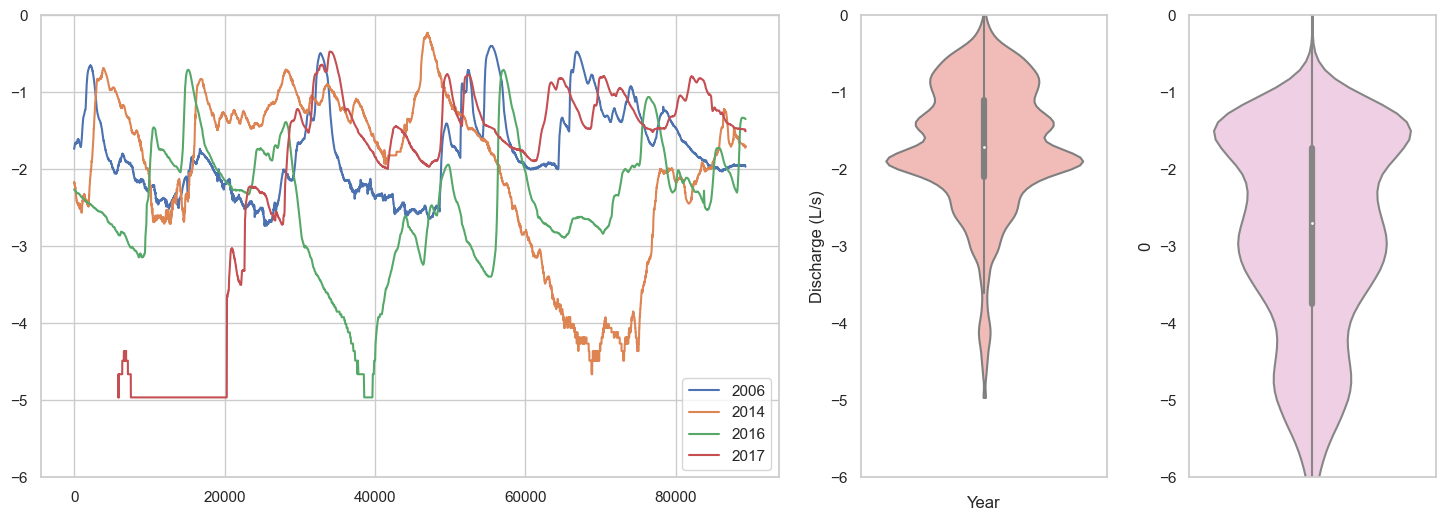

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1.5, 0.5, 0.5]})

ax[0].plot(IC_Discharge_2006['Minute of Year'] , np.log10(DOC_Riv_Flux_2006), label='2006')
ax[0].plot(IC_Discharge_2014['Minute of Year'] , np.log10(DOC_Riv_Flux_2014), label='2014')
ax[0].plot(IC_Discharge_2016['Minute of Year'] , np.log10(DOC_Riv_Flux_2016), label='2016')
ax[0].plot(IC_Discharge_2017['Minute of Year'] , np.log10(DOC_Riv_Flux_2017), label='2017')
# ax[0].plot(IC_Discharge_2017['Minute of Year'] , np.log10(DOC_Riv_Flux_2017_meanplusSD), label='2017 (mean + SD)', linestyle='--')
# ax[0].plot(IC_Discharge_2017['Minute of Year'] , np.log10(DOC_Riv_Flux_2017_meanminusSD), label='2017 (mean - SD)', linestyle='--')

ax[0].legend()
ax[0].set_ylim(-6, 0) 

sns.violinplot(ax=ax[1], data=filtered_data['Discharge (L/s)']* DOC_Riv_mean, y=np.log10(filtered_data['Discharge (L/s)']* DOC_Riv_mean), palette="Pastel1", dodge=False, orient='v', width=0.8, cut = 0)
ax[1].set_xlabel('Year')
ax[1].grid(False)
ax[1].set_ylim(-6, 0)

sns.violinplot(y=np.log10(C_soil_model[0]), palette = 'Pastel2_r', dodge=False, orient='v', cut = 0,  ax = ax[2])
ax[2].set_ylim(-6, 0)
ax[2].grid(False)
# fig.savefig('Stack_DOCFlux_comparison.pdf')
# 
# fig.savefig('Kane_DOCFlux_comparison_allyears_updated_1.pdf')